# Evaluation pipeline

## 0 Imports and Constants

In [1]:
import sys
import os

# Füge das übergeordnete Verzeichnis zu sys.path hinzu
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.insert(0, parent_dir)

In [2]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import seaborn as sns
from copy import deepcopy as dc

from utilities import split_data_into_sequences, load_sequential_time_series, reconstruct_sequential_data, Scaler, extract_features_and_targets_reg, get_discriminative_test_performance
from data_evaluation.visual.visual_evaluation import visual_evaluation
from predictive_evaluation import predictive_evaluation

In [3]:
DATA_FOLDER = Path("../../data")
REAL_DATA_FOLDER = DATA_FOLDER / "real"
SYNTHETIC_DATA_FOLDER = DATA_FOLDER / "synthetic" / "usable"

## 1 Load and Visualize Data

### Ways of loading data
- Laden der Originaldaten: als pd dataframe 
- Laden der synthetischen, sequentiellen Daten: als np array (GAN, (V)AE)
- Laden der synthetischen, sequentiellen Daten: als pd dataframe (brownian, algorithmit)

In [4]:
# possible types: 'timegan_lstm', 'timegan_gru', 'jitter', 'timewarp', 'autoencoder', 'vae'
syn_data_type = 'timegan_lstm'

In [5]:
# Load real time series
data_real_df = pd.read_csv(REAL_DATA_FOLDER/'metro_interstate_traffic_volume_label_encoded_no_categorical.csv')
data_real_numpy = dc(data_real_df).to_numpy()

if syn_data_type == 'timegan_lstm':
    # load sequential data (which should already be scaled)
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28499_12_5_lstm_unscaled.csv', shape=(28499, 12, 5))

elif syn_data_type == 'timegan_gru':
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28499_12_5_gru_unscaled.csv', shape=(28499, 12, 5))

elif syn_data_type == 'autoencoder':
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28478_12_5_lstm_autoencoder_unscaled_15.csv', shape=(28478, 12, 5))

elif syn_data_type == 'vae':
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28511_12_5_lstm_vae_unscaled.csv', shape=(28511, 12, 5))

elif syn_data_type == 'jitter':
    jitter_factor = 0.1
    data_syn_df = pd.read_csv(SYNTHETIC_DATA_FOLDER/f'mitv_jittered_{str(jitter_factor).replace(".", "")}.csv')
    data_syn_numpy = dc(data_syn_df).to_numpy()

elif syn_data_type == 'timewarp':
    data_syn_df = pd.read_csv(SYNTHETIC_DATA_FOLDER/f'mitv_time_warped.csv')
    data_syn_numpy = dc(data_syn_df).to_numpy()

# Loot at real and syn data
df = pd.DataFrame(data_syn_numpy.reshape(-1, data_syn_numpy.shape[-1]), columns=data_real_df.columns)

print('\n\n syn data:\n')
print(df.describe())

print('\n\nreal data:\n')
print(data_real_df.describe())



 syn data:

       traffic_volume           temp        rain_1h        snow_1h  \
count   341988.000000  341988.000000  341988.000000  341988.000000   
mean      3223.797936     282.704303       0.086439       0.000249   
std       1943.974204      12.922822       0.321004       0.000466   
min         41.627638     250.083873       0.000008       0.000000   
25%       1152.987320     270.511312       0.000130       0.000002   
50%       3608.409516     285.328962       0.000575       0.000006   
75%       5010.047921     293.711888       0.037928       0.000324   
max       7076.619110     305.881726      12.279954       0.004205   

          clouds_all  
count  341988.000000  
mean       39.871618  
std        39.339560  
min         0.016394  
25%         4.172619  
50%        15.465574  
75%        87.893841  
max        97.951007  


real data:

       traffic_volume          temp       rain_1h       snow_1h    clouds_all
count     28511.00000  28511.000000  28511.000000  28511

In [6]:
df.describe()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all
count,341988.000000,341988.000000,341988.000000,341988.000000,341988.000000
mean,3223.797936,282.704303,0.086439,0.000249,39.871618
std,1943.974204,12.922822,0.321004,0.000466,39.339560
min,41.627638,250.083873,0.000008,0.000000,0.016394
25%,1152.987320,270.511312,0.000130,0.000002,4.172619
50%,3608.409516,285.328962,0.000575,0.000006,15.465574
75%,5010.047921,293.711888,0.037928,0.000324,87.893841
max,7076.619110,305.881726,12.279954,0.004205,97.951007


In [7]:
data_real_df.describe()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all
count,28511.00000,28511.000000,28511.000000,28511.000000,28511.000000
mean,3313.74238,282.688768,0.061611,0.000250,42.122795
std,1971.53206,12.367361,0.678185,0.008298,39.316195
min,0.00000,243.390000,0.000000,0.000000,0.000000
25%,1289.00000,273.480000,0.000000,0.000000,1.000000
50%,3507.00000,284.550000,0.000000,0.000000,40.000000
75%,4948.00000,292.790000,0.000000,0.000000,90.000000
max,7280.00000,310.070000,42.000000,0.510000,100.000000


## 2 Predictive Evaluation

### Set Hyperparameters and Features

In [8]:
hyperparameters = {
    "seq_len": 12,
    "lr": 0.0001,
    "batch_size": 32,
    "hidden_size": 4,
    "num_layers": 1,
    "bidirectional": True,
    "num_evaluation_runs": 10,
    "num_epochs": 200,
    "device": 'cuda' if torch.cuda.is_available() else 'cpu'
}

In [9]:
# evaluate predictive performance
predictive_results = predictive_evaluation(data_real_numpy, data_syn_numpy, hyperparameters, include_baseline=True, verbose=True)

# save results
bidirectionality = "bi" if hyperparameters["bidirectional"] else 'no_bi'
predictive_results.to_csv(DATA_FOLDER / f"results_{syn_data_type}_{hyperparameters['num_epochs']}_{hyperparameters['num_evaluation_runs']}_{bidirectionality}.csv", index=False)

# split in mse and mae results
mse_results = predictive_results.loc[predictive_results['Metric'] == 'MSE']
mae_results = predictive_results.loc[predictive_results['Metric'] == 'MAE']

HYPERPARAMETERS:
seq_len :  12
lr :  0.0001
batch_size :  32
hidden_size :  4
num_layers :  1
bidirectional :  True
num_evaluation_runs :  10
num_epochs :  200
device :  cpu
Synthetic Data is sequential: True
Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (2841, 12, 5)
Shape of the data after splitting into sequences: (2840, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Train Loss: 0.5443368302070409 // Train Acc: 0.00438288920056101
Val Loss: 0.16472036098496298 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.014966908006355438 // Train Acc: 0.00438288920056101
Val Loss: 0.012216368083203777 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.008142099321296054 // Train Acc: 0.00438288920056101
Val Loss: 0.00521239361809462 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.00753815488584162 // Train Acc: 0.00438288920056101
Val Loss: 0.004539211659974764 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.007319685624883645 // Train Acc: 0.00876577840112202
Val Loss: 0.004319564303320446 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.007211941005048168 // Train Acc: 0.00876577840112202
Val Loss: 0.004226537860846252 // Val Acc: 0.0
*******

c:\Users\fanny\Documents\ArnesShit\time_series_data_augmentation\data_evaluation\predictive\predictive_evaluation.py:273: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([{'Model': evaluation_method, 'Metric': 'MAE', 'Error': mae}])], ignore_index=True)
 10%|█         | 1/10 [03:35<32:17, 215.27s/it]

Epoch: 1
Train Loss: 0.46782051793823404 // Train Acc: 0.00438288920056101
Val Loss: 0.2479787974545125 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.01576117673878353 // Train Acc: 0.00438288920056101
Val Loss: 0.013454122976347637 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.009463628701445076 // Train Acc: 0.00438288920056101
Val Loss: 0.006727460654075729 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.008443922722035545 // Train Acc: 0.00438288920056101
Val Loss: 0.005375561150042027 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.007779031072391868 // Train Acc: 0.00438288920056101
Val Loss: 0.004612437318591924 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.007243788112438222 // Train Acc: 0.00438288920056101
Val Loss: 0.004123430815525353 // Val Acc: 0.0
******

 20%|██        | 2/10 [07:10<28:42, 215.36s/it]

Epoch: 1
Train Loss: 0.17223015503349176 // Train Acc: 0.00876577840112202
Val Loss: 0.07341266009077597 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.013419253493007403 // Train Acc: 0.00438288920056101
Val Loss: 0.011129874150069911 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.009082455749703155 // Train Acc: 0.00438288920056101
Val Loss: 0.006507138794894968 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.00782111813777961 // Train Acc: 0.00438288920056101
Val Loss: 0.005175942340551802 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.007543657519390903 // Train Acc: 0.00438288920056101
Val Loss: 0.004797820498894775 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.00738167200485038 // Train Acc: 0.00438288920056101
Val Loss: 0.004558874806912428 // Val Acc: 0.0
******

 30%|███       | 3/10 [10:45<25:07, 215.30s/it]

Epoch: 1
Train Loss: 0.36389886095680996 // Train Acc: 0.00438288920056101
Val Loss: 0.15306977994656296 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.013373668306882051 // Train Acc: 0.00438288920056101
Val Loss: 0.010700326266416003 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.0076454849348783615 // Train Acc: 0.00438288920056101
Val Loss: 0.004844828880276908 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.007332994828756956 // Train Acc: 0.00438288920056101
Val Loss: 0.004355793824063593 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.007226267893867878 // Train Acc: 0.00438288920056101
Val Loss: 0.004219850818260333 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.0071406747365689105 // Train Acc: 0.00438288920056101
Val Loss: 0.004135776494284359 // Val Acc: 0.0
**

 40%|████      | 4/10 [14:20<21:29, 214.89s/it]

Epoch: 1
Train Loss: 0.3154649840665231 // Train Acc: 0.00438288920056101
Val Loss: 0.14744746015312965 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.014919772844756386 // Train Acc: 0.00438288920056101
Val Loss: 0.012445220247622622 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.00884896804197191 // Train Acc: 0.00438288920056101
Val Loss: 0.005589283267663938 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.007479953560011584 // Train Acc: 0.00438288920056101
Val Loss: 0.004383412413456048 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.007264092566868679 // Train Acc: 0.00438288920056101
Val Loss: 0.004219313367960577 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.007169734379981983 // Train Acc: 0.00438288920056101
Val Loss: 0.00411766964492252 // Val Acc: 0.0
*******

 50%|█████     | 5/10 [17:49<17:44, 212.83s/it]

Epoch: 1
Train Loss: 0.1575339981792351 // Train Acc: 0.00438288920056101
Val Loss: 0.08958310035339902 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.011780535957030169 // Train Acc: 0.00438288920056101
Val Loss: 0.009385275638798315 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.008042741797114677 // Train Acc: 0.00438288920056101
Val Loss: 0.005328445580233349 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.00768035029153879 // Train Acc: 0.00438288920056101
Val Loss: 0.004915117927083976 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.007495403295346283 // Train Acc: 0.00438288920056101
Val Loss: 0.004671545960846242 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.007367468236254588 // Train Acc: 0.00438288920056101
Val Loss: 0.004493743788157956 // Val Acc: 0.0
******

 60%|██████    | 6/10 [21:18<14:05, 211.44s/it]

Epoch: 1
Train Loss: 0.4750310824596196 // Train Acc: 0.00876577840112202
Val Loss: 0.22524350463004594 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.011508289921825012 // Train Acc: 0.00438288920056101
Val Loss: 0.00903373321235766 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.008290729604643178 // Train Acc: 0.00438288920056101
Val Loss: 0.005422262396412284 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.0074109164348099416 // Train Acc: 0.00438288920056101
Val Loss: 0.004481737146133117 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.00705425988759997 // Train Acc: 0.00438288920056101
Val Loss: 0.004109018844594196 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.006858981792458437 // Train Acc: 0.00438288920056101
Val Loss: 0.003941903666467563 // Val Acc: 0.0
******

 70%|███████   | 7/10 [24:47<10:32, 210.73s/it]

Epoch: 1
Train Loss: 0.5336886892019448 // Train Acc: 0.00438288920056101
Val Loss: 0.29774640919117445 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.014133132345971832 // Train Acc: 0.00438288920056101
Val Loss: 0.011998209605265535 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.012203814071925752 // Train Acc: 0.00438288920056101
Val Loss: 0.009640286679201748 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.008534016171901332 // Train Acc: 0.00438288920056101
Val Loss: 0.005980739657756653 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.00790139350048717 // Train Acc: 0.00438288920056101
Val Loss: 0.005194955518511072 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.007702441695688337 // Train Acc: 0.00438288920056101
Val Loss: 0.0049521354487521594 // Val Acc: 0.0
*****

 80%|████████  | 8/10 [28:17<07:01, 210.57s/it]

Epoch: 1
Train Loss: 0.30341463715757594 // Train Acc: 0.00438288920056101
Val Loss: 0.14548011986392267 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.016006175769547843 // Train Acc: 0.00438288920056101
Val Loss: 0.014032971710385232 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.01027367691846426 // Train Acc: 0.00438288920056101
Val Loss: 0.007750300779478268 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.008201313483937635 // Train Acc: 0.00438288920056101
Val Loss: 0.005410063198212994 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.0077458691966444315 // Train Acc: 0.00438288920056101
Val Loss: 0.004879051911006315 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.007610051403361599 // Train Acc: 0.00438288920056101
Val Loss: 0.004696687016364062 // Val Acc: 0.0
****

 90%|█████████ | 9/10 [31:46<03:30, 210.20s/it]

Epoch: 1
Train Loss: 0.22264377645322686 // Train Acc: 0.00876577840112202
Val Loss: 0.10442083680562758 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.013957120248914642 // Train Acc: 0.00438288920056101
Val Loss: 0.01157669180983238 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.008105525467414174 // Train Acc: 0.00438288920056101
Val Loss: 0.005401782322612204 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.007371380890400879 // Train Acc: 0.00438288920056101
Val Loss: 0.004527366856175862 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.0071050111324556416 // Train Acc: 0.00438288920056101
Val Loss: 0.0042227775805493755 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.006783008345221215 // Train Acc: 0.00438288920056101
Val Loss: 0.003931892362130241 // Val Acc: 0.0
***

100%|██████████| 10/10 [35:16<00:00, 211.68s/it]


Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (5692, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Train Loss: 0.08426985918409693 // Train Acc: 0.00438288920056101
Val Loss: 0.06790068379362647 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.011364002924328893 // Train Acc: 0.00438288920056101
Val Loss: 0.009664478154559985 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.00851436935235886 // Train Acc: 0.00438288920056101
Val Loss: 0.006785970305490276 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.007788486212170663 // Train Acc: 0.00438288920056101
Val Loss: 0.005898791997107479 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.0074496425082188665 // Train Acc: 0.00438288920056101
Val Loss: 0.005422796142350338 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.007230002681240126 // Train Acc: 0.00438288920056101
Val Loss: 0.005102484946118228 // Val Acc: 0.0
****

 10%|█         | 1/10 [03:31<31:44, 211.61s/it]

Epoch: 1
Train Loss: 0.23802866804482725 // Train Acc: 0.00438288920056101
Val Loss: 0.15903156924616085 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.012571676402727631 // Train Acc: 0.00438288920056101
Val Loss: 0.01119727209430146 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.00854896024904027 // Train Acc: 0.00438288920056101
Val Loss: 0.006711615206349348 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.007747910888721908 // Train Acc: 0.00438288920056101
Val Loss: 0.005538912100215139 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.00737538052132408 // Train Acc: 0.00438288920056101
Val Loss: 0.0050524898145473405 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.007154899346609541 // Train Acc: 0.00438288920056101
Val Loss: 0.0047912342131158775 // Val Acc: 0.0
*****

 20%|██        | 2/10 [07:03<28:13, 211.73s/it]

Epoch: 1
Train Loss: 0.14100372085418306 // Train Acc: 0.00438288920056101
Val Loss: 0.06977201112954134 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.011678048792565543 // Train Acc: 0.00438288920056101
Val Loss: 0.009841680293902755 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.00857526905211616 // Train Acc: 0.00438288920056101
Val Loss: 0.006420506406418477 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.0077574637951655905 // Train Acc: 0.00438288920056101
Val Loss: 0.005432782889594942 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.007476747037286427 // Train Acc: 0.00438288920056101
Val Loss: 0.00507488126115706 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.007315299437619056 // Train Acc: 0.00438288920056101
Val Loss: 0.004887588031124324 // Val Acc: 0.0
*****

 30%|███       | 3/10 [10:35<24:44, 212.03s/it]

Epoch: 1
Train Loss: 0.10507136298053563 // Train Acc: 0.00438288920056101
Val Loss: 0.07692541052283866 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.01195457707770524 // Train Acc: 0.00438288920056101
Val Loss: 0.0103607926062528 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.008036692760660095 // Train Acc: 0.00438288920056101
Val Loss: 0.006073094143145038 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.007394516049018247 // Train Acc: 0.00438288920056101
Val Loss: 0.00511128893331363 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.007162586859979917 // Train Acc: 0.00438288920056101
Val Loss: 0.004755999170259436 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.007052101117792588 // Train Acc: 0.00438288920056101
Val Loss: 0.0046244373393318295 // Val Acc: 0.0
*******

 40%|████      | 4/10 [14:08<21:13, 212.25s/it]

Epoch: 1
Train Loss: 0.09794463919473062 // Train Acc: 0.00438288920056101
Val Loss: 0.06993502575192559 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.013462576695141835 // Train Acc: 0.00438288920056101
Val Loss: 0.011900397582670277 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.009034356971951868 // Train Acc: 0.00438288920056101
Val Loss: 0.007025785958708337 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.008074843016457006 // Train Acc: 0.00438288920056101
Val Loss: 0.005883075324347599 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.007656794186710245 // Train Acc: 0.00438288920056101
Val Loss: 0.005322250071913004 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.007449957565306509 // Train Acc: 0.00438288920056101
Val Loss: 0.005019894099972221 // Val Acc: 0.0
****

 50%|█████     | 5/10 [17:40<17:41, 212.33s/it]

Epoch: 1
Train Loss: 0.1963502330206554 // Train Acc: 0.00438288920056101
Val Loss: 0.11794149323125903 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.01491185736504147 // Train Acc: 0.00438288920056101
Val Loss: 0.013374529663850082 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.010196413753389644 // Train Acc: 0.00438288920056101
Val Loss: 0.00799205053330849 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.008663709690143859 // Train Acc: 0.00438288920056101
Val Loss: 0.006213847944104856 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.008025326630718442 // Train Acc: 0.00438288920056101
Val Loss: 0.00547676314495169 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.007558103785020669 // Train Acc: 0.00438288920056101
Val Loss: 0.005036810029748032 // Val Acc: 0.0
********

 60%|██████    | 6/10 [21:13<14:09, 212.30s/it]

Epoch: 1
Train Loss: 0.07092467704879285 // Train Acc: 0.00438288920056101
Val Loss: 0.06357075742791209 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.010409463398474652 // Train Acc: 0.00438288920056101
Val Loss: 0.008580733332626019 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.007760652077422173 // Train Acc: 0.00438288920056101
Val Loss: 0.005670877266413627 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.007312825521412417 // Train Acc: 0.00438288920056101
Val Loss: 0.004987673423242535 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.007137546421918198 // Train Acc: 0.00438288920056101
Val Loss: 0.004683249192495485 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.007051425263335273 // Train Acc: 0.00438288920056101
Val Loss: 0.004545725345104053 // Val Acc: 0.0
****

 70%|███████   | 7/10 [24:45<10:37, 212.49s/it]

Epoch: 1
Train Loss: 0.08271359081208957 // Train Acc: 0.00438288920056101
Val Loss: 0.07570028217153603 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.010238390674861606 // Train Acc: 0.00438288920056101
Val Loss: 0.008296073418309432 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.008004633929883488 // Train Acc: 0.00438288920056101
Val Loss: 0.005731884280240603 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.007530012874319356 // Train Acc: 0.00438288920056101
Val Loss: 0.005077230356884807 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.0073300618652207316 // Train Acc: 0.00438288920056101
Val Loss: 0.004785486309281602 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.007181151736420572 // Train Acc: 0.00438288920056101
Val Loss: 0.004587126619135438 // Val Acc: 0.0
***

 80%|████████  | 8/10 [28:19<07:05, 212.72s/it]

Epoch: 1
Train Loss: 0.8636636978947932 // Train Acc: 0.00876577840112202
Val Loss: 0.5956535113326619 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.017591667385722234 // Train Acc: 0.00438288920056101
Val Loss: 0.015310300375450026 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.00903143358157574 // Train Acc: 0.00438288920056101
Val Loss: 0.006951114480001747 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.008089824057828118 // Train Acc: 0.00438288920056101
Val Loss: 0.005756948397003031 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.007580248698419767 // Train Acc: 0.00438288920056101
Val Loss: 0.0051954837079065735 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.007305335994747168 // Train Acc: 0.00438288920056101
Val Loss: 0.0049135470357357285 // Val Acc: 0.0
*****

 90%|█████████ | 9/10 [31:51<03:32, 212.65s/it]

Epoch: 1
Train Loss: 0.4730267705706694 // Train Acc: 0.00876577840112202
Val Loss: 0.253670667748103 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.014508722365675769 // Train Acc: 0.00876577840112202
Val Loss: 0.013042778545844087 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.010362430459977784 // Train Acc: 0.00438288920056101
Val Loss: 0.008512618060726045 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.008913314910109193 // Train Acc: 0.00438288920056101
Val Loss: 0.00700062904585404 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.00834495945817949 // Train Acc: 0.00438288920056101
Val Loss: 0.0063763557805083275 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.008111459186736907 // Train Acc: 0.00438288920056101
Val Loss: 0.006103975774218025 // Val Acc: 0.0
********

100%|██████████| 10/10 [35:24<00:00, 212.46s/it]


Shape of the data after splitting into sequences: (28500, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Train Loss: 0.044344251667153285 // Train Acc: 0.0
Val Loss: 0.034458460026113684 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.0030152752739475287 // Train Acc: 0.0
Val Loss: 0.0031002305477972054 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.002287654847339015 // Train Acc: 0.0
Val Loss: 0.0023672713354417232 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.001879619755516048 // Train Acc: 0.0
Val Loss: 0.0019683230574978985 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.0016324150904707432 // Train Acc: 0.0
Val Loss: 0.0017434769760760057 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.001536901977014771 // Train Acc: 0.0
Val Loss: 0.0016641867529651588 // Val Acc: 0.0
**************************************************
Epoch: 61
Train Loss: 0.0014958142299746

 10%|█         | 1/10 [03:31<31:43, 211.52s/it]

Epoch: 1
Train Loss: 0.2859216224386515 // Train Acc: 0.0
Val Loss: 0.11951763979965747 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.005894174047440113 // Train Acc: 0.0
Val Loss: 0.005775765976322263 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.002603026880388936 // Train Acc: 0.0
Val Loss: 0.0026873605925454526 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.0021709766064468136 // Train Acc: 0.0
Val Loss: 0.0022485702381177947 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.0018977749189260699 // Train Acc: 0.0
Val Loss: 0.0019800755975432384 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.0016902947915847927 // Train Acc: 0.0
Val Loss: 0.0017818771224656252 // Val Acc: 0.0
**************************************************
Epoch: 61
Train Loss: 0.00155911273248301 /

 20%|██        | 2/10 [07:02<28:11, 211.38s/it]

Epoch: 1
Train Loss: 0.08259652570140813 // Train Acc: 0.0
Val Loss: 0.0643580965073415 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.0042864140430086545 // Train Acc: 0.0
Val Loss: 0.004337844379667671 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.0025959703555333245 // Train Acc: 0.0
Val Loss: 0.002630264579914198 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.00200901380118027 // Train Acc: 0.0
Val Loss: 0.0020600003980531995 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.0017282611109283041 // Train Acc: 0.0
Val Loss: 0.0018201258167489197 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.0016518080049308034 // Train Acc: 0.0
Val Loss: 0.001755989381527091 // Val Acc: 0.0
**************************************************
Epoch: 61
Train Loss: 0.0016092057592923875 /

 30%|███       | 3/10 [10:34<24:41, 211.70s/it]

Epoch: 1
Train Loss: 0.06347824402184842 // Train Acc: 0.0
Val Loss: 0.0534099161458415 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.003942365332543824 // Train Acc: 0.0
Val Loss: 0.004016809081580677 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.002135267749714154 // Train Acc: 0.0
Val Loss: 0.0022061967953334576 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.001760052174994615 // Train Acc: 0.0
Val Loss: 0.0018762833661238492 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.0016698790020632673 // Train Acc: 0.0
Val Loss: 0.0018002643353499566 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.0016208809279107852 // Train Acc: 0.0
Val Loss: 0.0017533138124129148 // Val Acc: 0.0
**************************************************
Epoch: 61
Train Loss: 0.0015868967397205092 

 40%|████      | 4/10 [14:06<21:09, 211.53s/it]

Epoch: 1
Train Loss: 0.08888720087759291 // Train Acc: 0.0
Val Loss: 0.06280643397203371 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.0037464831572360403 // Train Acc: 0.0
Val Loss: 0.0037783706735028733 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.0023673896609298067 // Train Acc: 0.0
Val Loss: 0.0024264027399021363 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.0018700815554460717 // Train Acc: 0.0
Val Loss: 0.0019589388684835285 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.0016465060063311243 // Train Acc: 0.0
Val Loss: 0.0017690771403585889 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.0015740424244720776 // Train Acc: 0.0
Val Loss: 0.0017079822573577985 // Val Acc: 0.0
**************************************************
Epoch: 61
Train Loss: 0.001535366515372

 50%|█████     | 5/10 [17:38<17:38, 211.68s/it]

Epoch: 1
Train Loss: 0.06718119999281487 // Train Acc: 0.0
Val Loss: 0.05827670057392653 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.003651159367870884 // Train Acc: 0.0
Val Loss: 0.003861118435167692 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.0024751422416221555 // Train Acc: 0.0
Val Loss: 0.0026280117720656887 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.0020880998583882133 // Train Acc: 0.0
Val Loss: 0.002203359604681785 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.001801733334932795 // Train Acc: 0.0
Val Loss: 0.0019128926258661664 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.0015731967895134674 // Train Acc: 0.0
Val Loss: 0.0017120945740519767 // Val Acc: 0.0
**************************************************
Epoch: 61
Train Loss: 0.0015069346127028775

 60%|██████    | 6/10 [21:10<14:07, 211.83s/it]

Epoch: 1
Train Loss: 0.1285584927817381 // Train Acc: 0.0
Val Loss: 0.08815351197256723 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.004384034505110041 // Train Acc: 0.0
Val Loss: 0.004297251868394708 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.0023682775887951964 // Train Acc: 0.0
Val Loss: 0.0024284216134377117 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.0018718770964689642 // Train Acc: 0.0
Val Loss: 0.001966651563868239 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.0016988645574511623 // Train Acc: 0.0
Val Loss: 0.0018144235134094839 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.0016155402724442383 // Train Acc: 0.0
Val Loss: 0.0017331123322621767 // Val Acc: 0.0
**************************************************
Epoch: 61
Train Loss: 0.0015583378171179572

 70%|███████   | 7/10 [24:41<10:35, 211.69s/it]

Epoch: 1
Train Loss: 0.5727524693851551 // Train Acc: 0.0
Val Loss: 0.4211711099360908 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.006254926559007184 // Train Acc: 0.0
Val Loss: 0.0061330537067195556 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.003124614819367697 // Train Acc: 0.0
Val Loss: 0.0031647390924009113 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.002121250809912882 // Train Acc: 0.0
Val Loss: 0.0021704177023561975 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.0017785784310604437 // Train Acc: 0.0
Val Loss: 0.0018627331502717405 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.0016281873068446032 // Train Acc: 0.0
Val Loss: 0.001737258580770843 // Val Acc: 0.0
**************************************************
Epoch: 61
Train Loss: 0.0015615856371376518 /

 80%|████████  | 8/10 [28:13<07:03, 211.74s/it]

Epoch: 1
Train Loss: 0.07294985634205552 // Train Acc: 0.0
Val Loss: 0.06220812402540745 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.00391902288322064 // Train Acc: 0.0
Val Loss: 0.0038774533921790274 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.0021528757666221324 // Train Acc: 0.0
Val Loss: 0.0022117027758579056 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.0017290920382886433 // Train Acc: 0.0
Val Loss: 0.0018268048643933182 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.001598723183600245 // Train Acc: 0.0
Val Loss: 0.001714067469551306 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.0015458383969782993 // Train Acc: 0.0
Val Loss: 0.0016684148107153265 // Val Acc: 0.0
**************************************************
Epoch: 61
Train Loss: 0.0015115866963994894

 90%|█████████ | 9/10 [31:45<03:31, 211.74s/it]

Epoch: 1
Train Loss: 0.06973617501964409 // Train Acc: 0.0
Val Loss: 0.06121800057381891 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.004644754964487332 // Train Acc: 0.0
Val Loss: 0.004781188576627918 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.002947079404639302 // Train Acc: 0.0
Val Loss: 0.0029374094141449507 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.002100832617508906 // Train Acc: 0.0
Val Loss: 0.0021689041132658886 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.0018141436891262596 // Train Acc: 0.0
Val Loss: 0.001889912425553395 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.0016486944417790203 // Train Acc: 0.0
Val Loss: 0.0017307753459740347 // Val Acc: 0.0
**************************************************
Epoch: 61
Train Loss: 0.0015380977642394898 

100%|██████████| 10/10 [35:16<00:00, 211.66s/it]


Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (2841, 12, 5)
Shape of the data after splitting into sequences: (2840, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Train Loss: 0.13658790774348153 // Train Acc: 0.004128137384412154
Val Loss: 0.06550388739266422 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.0051994526245455345 // Train Acc: 0.002064068692206077
Val Loss: 0.004295591552731361 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.004762809369121764 // Train Acc: 0.002064068692206077
Val Loss: 0.0037603120769510107 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.004637681053892329 // Train Acc: 0.002064068692206077
Val Loss: 0.0036405001647948298 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.0045579458800286896 // Train Acc: 0.002064068692206077
Val Loss: 0.0035891204927210813 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.00449395410626108 // Train Acc: 0.002064068692206077
Val Loss: 0.0035690906156100374 // Val Ac

 10%|█         | 1/10 [07:13<1:04:57, 433.00s/it]

Epoch: 1
Train Loss: 0.25124366545269716 // Train Acc: 0.004128137384412154
Val Loss: 0.0666524652140529 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.00621413948713947 // Train Acc: 0.002064068692206077
Val Loss: 0.005390260808413137 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.005103581578607943 // Train Acc: 0.002064068692206077
Val Loss: 0.004116323365165402 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.004926435348168422 // Train Acc: 0.002064068692206077
Val Loss: 0.0038614568138348585 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.004841065889853699 // Train Acc: 0.002064068692206077
Val Loss: 0.0037435338347810163 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.004785857314771088 // Train Acc: 0.002064068692206077
Val Loss: 0.0036817992114582298 // Val Acc: 0

 20%|██        | 2/10 [14:25<57:40, 432.56s/it]  

Epoch: 1
Train Loss: 0.1403765632663921 // Train Acc: 0.004128137384412154
Val Loss: 0.04968264906175351 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.006380675476206813 // Train Acc: 0.004128137384412154
Val Loss: 0.005657342473160099 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.0052003626061693856 // Train Acc: 0.002064068692206077
Val Loss: 0.004412492207418918 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.004861957111679321 // Train Acc: 0.002064068692206077
Val Loss: 0.003995997199116358 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.004740695330290348 // Train Acc: 0.002064068692206077
Val Loss: 0.0038207380321489 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.004680978597513655 // Train Acc: 0.002064068692206077
Val Loss: 0.003727514829141287 // Val Acc: 0.0


 30%|███       | 3/10 [21:37<50:26, 432.34s/it]

Epoch: 1
Train Loss: 0.0793420695890445 // Train Acc: 0.002064068692206077
Val Loss: 0.05338449719665426 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.005790337071487375 // Train Acc: 0.002064068692206077
Val Loss: 0.004517742211922605 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.0049651272008930615 // Train Acc: 0.002064068692206077
Val Loss: 0.003545290782650033 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.0048054049268146225 // Train Acc: 0.002064068692206077
Val Loss: 0.003422468195975434 // Val Acc: 0.0
**************************************************
INFO: Validation loss did not improve in epoch 41
Epoch: 41
Train Loss: 0.004724675401244952 // Train Acc: 0.002064068692206077
Val Loss: 0.0034131283572288963 // Val Acc: 0.0
**************************************************
INFO: Validation loss did not improve in epoch 42
INFO: Validation loss

 40%|████      | 4/10 [23:14<30:00, 300.07s/it]

INFO: Validation loss did not improve in epoch 45
Early stopping after 45 epochs
Epoch: 1
Train Loss: 0.05247540287968741 // Train Acc: 0.002064068692206077
Val Loss: 0.03285270740979173 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.005054544325100745 // Train Acc: 0.002064068692206077
Val Loss: 0.004083370940963832 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.00474542437529264 // Train Acc: 0.002064068692206077
Val Loss: 0.0036529998203119513 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.0046476622046467565 // Train Acc: 0.002064068692206077
Val Loss: 0.003541496485698016 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.004570905169026276 // Train Acc: 0.002064068692206077
Val Loss: 0.0034639356661786773 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.0045014458129156

 50%|█████     | 5/10 [29:33<27:21, 328.35s/it]

INFO: Validation loss did not improve in epoch 175
Early stopping after 175 epochs
Epoch: 1
Train Loss: 0.19074838435894945 // Train Acc: 0.004128137384412154
Val Loss: 0.04755104474430339 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.005627627308724037 // Train Acc: 0.002064068692206077
Val Loss: 0.005212040928066865 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.004873622996174968 // Train Acc: 0.002064068692206077
Val Loss: 0.004024754773453924 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.004740371585758544 // Train Acc: 0.002064068692206077
Val Loss: 0.003692420898659385 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.004692380516726033 // Train Acc: 0.002064068692206077
Val Loss: 0.0036195911515472727 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.004658221081506

 60%|██████    | 6/10 [36:45<24:15, 363.84s/it]

Epoch: 1
Train Loss: 0.09403583182137622 // Train Acc: 0.002064068692206077
Val Loss: 0.042368601149555006 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.006096460372151111 // Train Acc: 0.004128137384412154
Val Loss: 0.005262912100957958 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.004993266358880401 // Train Acc: 0.002064068692206077
Val Loss: 0.003787920414110426 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.004812670643494435 // Train Acc: 0.002064068692206077
Val Loss: 0.003670042360415996 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.004712202483485945 // Train Acc: 0.002064068692206077
Val Loss: 0.0035839991798046244 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.0046331441783299485 // Train Acc: 0.002064068692206077
Val Loss: 0.003544234484793838 // Val Acc:

 70%|███████   | 7/10 [39:00<14:26, 288.81s/it]

INFO: Validation loss did not improve in epoch 62
Early stopping after 62 epochs
Epoch: 1
Train Loss: 0.19238662134605009 // Train Acc: 0.004128137384412154
Val Loss: 0.06312016343300263 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.0058636600182799545 // Train Acc: 0.002064068692206077
Val Loss: 0.0049192592239378835 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.005028121636544085 // Train Acc: 0.002064068692206077
Val Loss: 0.0038854674597367583 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.004825951831333482 // Train Acc: 0.002064068692206077
Val Loss: 0.0036763101124552633 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.004712339743686246 // Train Acc: 0.002064068692206077
Val Loss: 0.003596926584945772 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.00463572813304

 80%|████████  | 8/10 [44:49<10:16, 308.05s/it]

INFO: Validation loss did not improve in epoch 161
Early stopping after 161 epochs
Epoch: 1
Train Loss: 0.08345506431306055 // Train Acc: 0.002064068692206077
Val Loss: 0.05824228292435742 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.0054646812905612815 // Train Acc: 0.002064068692206077
Val Loss: 0.004240151807035351 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.0049692450703192155 // Train Acc: 0.002064068692206077
Val Loss: 0.003555869530255938 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.004869754890189414 // Train Acc: 0.002064068692206077
Val Loss: 0.0034687591044969984 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.004804339145773578 // Train Acc: 0.002064068692206077
Val Loss: 0.0034491641890372704 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.004749892830

 90%|█████████ | 9/10 [52:08<05:48, 348.89s/it]

Epoch: 1
Train Loss: 0.17576842900990575 // Train Acc: 0.004128137384412154
Val Loss: 0.047928934226210196 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.0057303445648846105 // Train Acc: 0.002064068692206077
Val Loss: 0.004730348776126009 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.005037950094225029 // Train Acc: 0.002064068692206077
Val Loss: 0.0038755395216867328 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.004874083435208576 // Train Acc: 0.002064068692206077
Val Loss: 0.0036402271875426214 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.004806853895442551 // Train Acc: 0.002064068692206077
Val Loss: 0.0035767079794680008 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.004755556337444494 // Train Acc: 0.002064068692206077
Val Loss: 0.0035530227456199988 // Val A

100%|██████████| 10/10 [59:27<00:00, 356.79s/it]


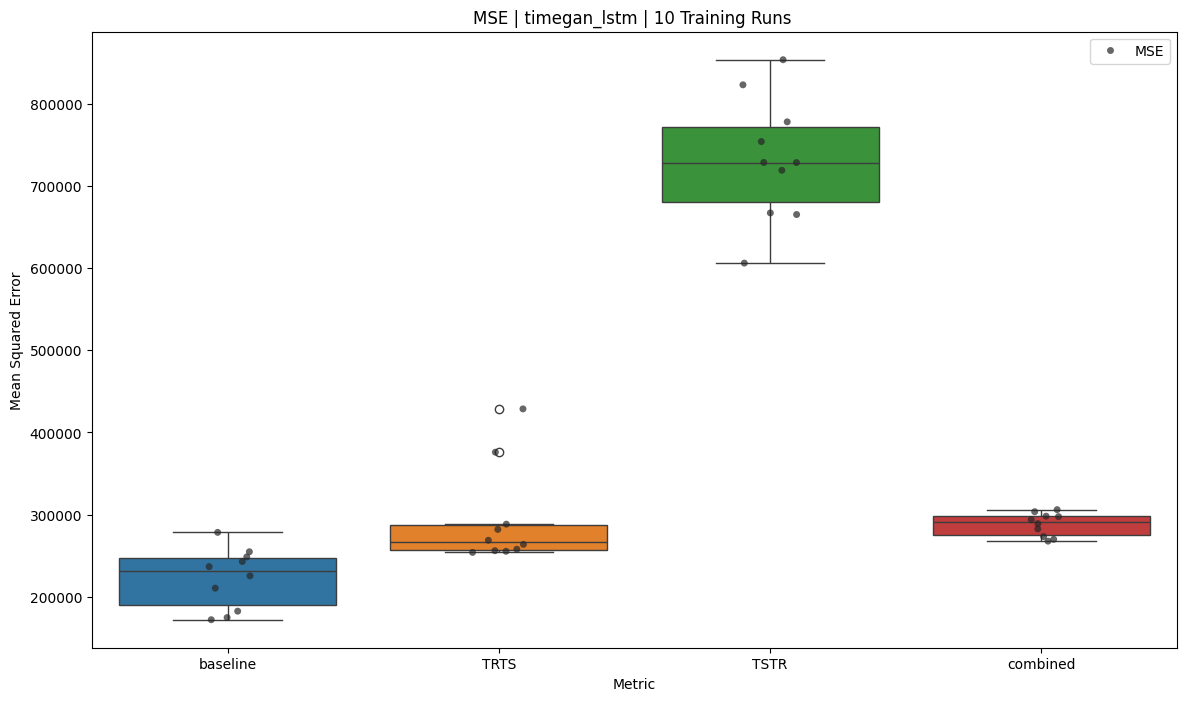

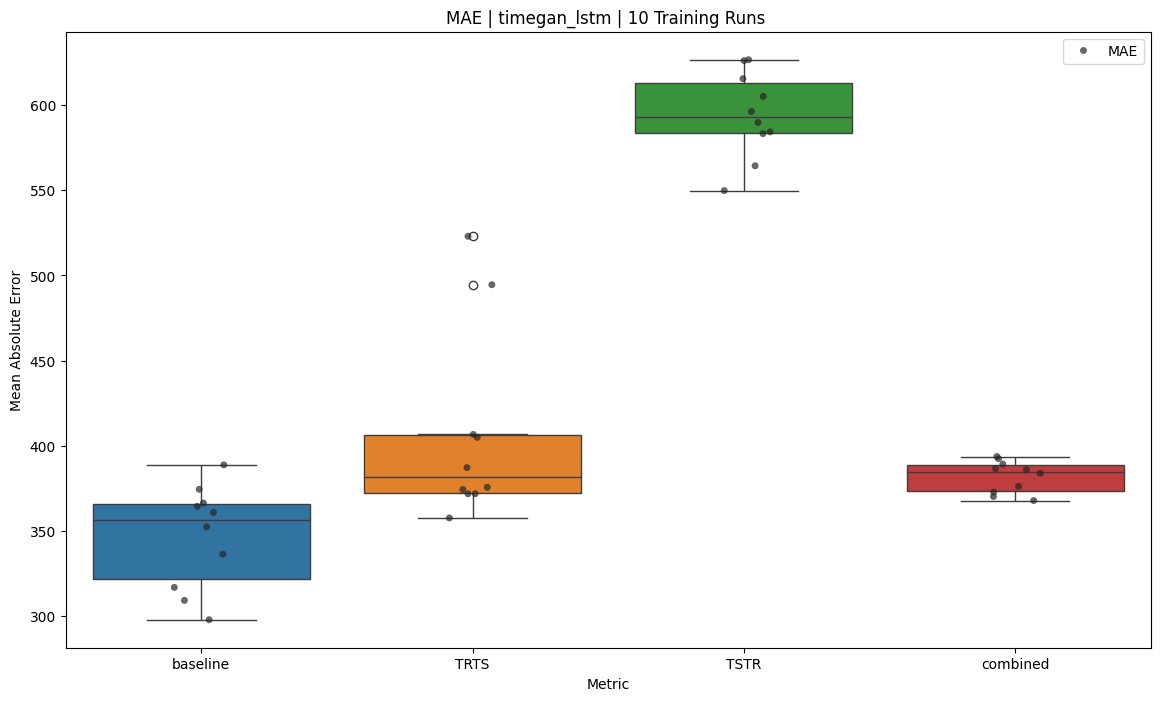

In [10]:
# plot results
plt.figure(figsize=(14, 8))
sns.boxplot(x='Model', y='Error', hue='Model', data=mse_results)
sns.stripplot(x='Model', y='Error', hue='Metric', data=mse_results, dodge=True, jitter=True, palette='dark:black', alpha=0.7)
plt.ylabel('Mean Squared Error')
plt.xlabel('Metric')
plt.title(f'MSE | {syn_data_type} | {hyperparameters["num_evaluation_runs"]} Training Runs {" | jitter factor = " + str(jitter_factor) if syn_data_type == "jitter" else ""}')
plt.legend()

plt.figure(figsize=(14, 8))
sns.boxplot(x='Model', y='Error', hue='Model', data=mae_results)
sns.stripplot(x='Model', y='Error', hue='Metric', data=mae_results, dodge=True, jitter=True, palette='dark:black', alpha=0.7)
plt.ylabel('Mean Absolute Error')
plt.xlabel('Metric')
plt.title(f'MAE | {syn_data_type} | {hyperparameters["num_evaluation_runs"]} Training Runs {" | jitter factor = " + str(jitter_factor) if syn_data_type == "jitter" else ""}')
plt.legend()

In [11]:
0.2*1e06

200000.0